In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from Bio import SeqIO
from Bio import SearchIO
import csv
import sqlite3
import time
from multiprocessing import Pool, cpu_count
import sys
from calc_icity_ import *

In [2]:
tnpB_path = "tnpB_icity_output.csv"

In [5]:
tnpB_df = pd.read_csv(tnpB_path).rename(columns={" icity": "icity", " numer": "numer", " denom": "denom"}).drop_duplicates()

In [6]:
def get_prot_sequence(pid):
    con=sqlite3.connect("80kprotein_stats.db")
    cur = con.cursor()
    cmd = "SELECT sequence FROM proteins WHERE pid = '%s'" % pid 
    #print(cmd)
    cur.execute(cmd)
    return str(cur.fetchone()[0])
    con.close()

In [7]:
tnpB_df = tnpB_df[tnpB_df["icity"] > .7].sort_values(["icity","numer"], ascending = False)
tnpB_df_0 = tnpB_df
tnpB_df_5 = tnpB_df[tnpB_df["denom"] > 5]
tnpB_df_10 = tnpB_df[tnpB_df["denom"] > 10]
tnpB_df_20 = tnpB_df[tnpB_df["denom"] > 20]
tnpB_df_40 = tnpB_df[tnpB_df["denom"] > 40]
tnpB_df_80 = tnpB_df[tnpB_df["denom"] > 80]
tnpB_df_160 = tnpB_df[tnpB_df["denom"] > 160]
tnpB_df_320 = tnpB_df[tnpB_df["denom"] > 320]
tnpB_df_l = [tnpB_df_0, tnpB_df_5, tnpB_df_10, tnpB_df_20, tnpB_df_40, tnpB_df_80, tnpB_df_160, tnpB_df_320]
[df.shape for df in tnpB_df_l]

[(122348, 4),
 (7839, 4),
 (4429, 4),
 (2130, 4),
 (1044, 4),
 (374, 4),
 (166, 4),
 (63, 4)]

In [8]:
tnpB_df

,target_p100id,icity,numer,denom
6113,73e8b2cdaa20ebcfab,1.000000,99,99
100909,ab02016b04a6bef115,1.000000,63,63
94170,61a1300255d2520879,1.000000,51,51
401842,97c77cd000432072a3,1.000000,45,45
16920,35b1dd79089736fe93,1.000000,42,42
...,...,...,...,...
257144,562f3ac1891bab6106,0.702128,33,47
452510,fb4446cade186a3056,0.701863,113,161
265610,7263e8f1ef05558c21,0.701754,40,57
50233,21adfc87af74481d93,0.701493,47,67


In [6]:
arg_suffixes = [str(i) for i in [0, 5, 10, 20, 40, 80, 160, 320]]

In [7]:
tnpB_multifaa_path_l = ["../tnpBs/data/hmmer_input_tnpb_" + i + ".faa" for i in arg_suffixes]
out_raw_path_l = ["../tnpBs/data/out_raw_path_" + i + ".out" for i in arg_suffixes]
out_clean_path_l = ["../tnpBs/output/out_raw_path_" + i + ".csv" for i in arg_suffixes]

In [8]:
def hmmsearch_tnpBneighb(tnpB_df, tnpB_multifaa_path, out_raw_path, out_clean_path):
    print("generating hmmsearch multifaa input file")
    with open(tnpB_multifaa_path, 'w') as outfile:
        for tnpBid in tnpB_df["target_p100id"]:
            tnpB_seq = get_prot_sequence(tnpBid)
            print(">" + tnpBid, file = outfile)
            print(tnpB_seq, file = outfile)
    pfam_command = "hmmsearch --cpu {threads} -E 1 --domtblout {outtbl} {hmmfile} {seqdb}".format(
    threads = cpu_count(), outtbl=out_raw_path, hmmfile='../tnpBs/data/Pfam-A.hmm', seqdb=tnpB_multifaa_path)
    print("running hmmsearch")
    os.system(pfam_command)
    print("formatting hmmsearch results")
    with open(out_raw_path, 'r') as infile, open(out_clean_path, "w") as outfile:
        print("query_id,query_accession, query_len,hit_id,hit_evalue,target_length", file=outfile)
        for qresult in SearchIO.parse(infile, 'hmmscan3-domtab'):
            query_id = qresult.id  #sequence ID from fasta
            query_accession = qresult.accession
            query_len = qresult.seq_len
            hits = qresult.hits
            num_hits = len(hits)
            if num_hits > 0:
                for i in range(0,num_hits): 
                    hit_evalue = hits[i].evalue
                    target_length = hits[i].seq_len
                    hit_id = hits[i].id
                    out_row = ",".join([query_id, query_accession, str(query_len), hit_id, str(hit_evalue), str(target_length)])
                    print(out_row, file=outfile)

In [9]:
# for i in range(len(tnpB_df_l)):
#     hmmsearch_tnpBneighb(tnpB_df_l[i], tnpB_multifaa_path_l[i], out_raw_path_l[i], out_clean_path_l[i])

## identify common pfam domains

In [16]:
df_pfam_320, df_pfam_160, df_pfam_80, df_pfam_40, df_pfam_20, df_pfam_10, df_pfam_5, df_pfam_0 = pd.read_csv(out_clean_path_l[7]), pd.read_csv(out_clean_path_l[6]), pd.read_csv(out_clean_path_l[5]), pd.read_csv(out_clean_path_l[4]), pd.read_csv(out_clean_path_l[3]), pd.read_csv(out_clean_path_l[2]), pd.read_csv(out_clean_path_l[1]), pd.read_csv(out_clean_path_l[0])
df_pfam_clustsize_list = [df_pfam_320, df_pfam_160, df_pfam_80, df_pfam_40, df_pfam_20, df_pfam_10, df_pfam_5, df_pfam_0]
# filter pfam df by evalues
df_pfam_evaluefiltered_list = [df[df["hit_evalue"] < 1e-4] for df in df_pfam_clustsize_list]
[df_pfam_320, df_pfam_160, df_pfam_80, df_pfam_40, df_pfam_20, df_pfam_10, df_pfam_5, df_pfam_0] = df_pfam_evaluefiltered_list

def dict_topn_pfam(df, n):
    queryid_frequency_dict = {}
    for i in range(n):
        key = df["query_id"].value_counts().index[i]
        value = df["query_id"].value_counts()[i] / len(df["query_id"]) * 100
        queryid_frequency_dict[key] = value
    return queryid_frequency_dict
dict_top10_320, dict_top10_160, dict_top10_80, dict_top10_40, dict_top10_20, dict_top10_10, dict_top10_5, dict_top10_0 = dict_topn_pfam(df_pfam_320, 10), dict_topn_pfam(df_pfam_160, 10), dict_topn_pfam(df_pfam_80, 10), dict_topn_pfam(df_pfam_40, 10), dict_topn_pfam(df_pfam_20, 10), dict_topn_pfam(df_pfam_10, 10), dict_topn_pfam(df_pfam_5, 10), dict_topn_pfam(df_pfam_0, 10)


In [17]:
all_dict_top10pfams = [dict_top10_320, dict_top10_160, dict_top10_80, dict_top10_40, dict_top10_20, dict_top10_10, dict_top10_5, dict_top10_0]
merged_dict_top10pfams = all_dict_top10pfams[0]
for dict_ in all_dict_top10pfams[1:]:
    merged_dict_top10pfams.update(dict_)

In [18]:
# argument for dict_globaltop_pfam()
list_top10pfams = list(merged_dict_top10pfams.keys())

In [194]:
df_pfam_10["query_id"].value_counts()[:10]

Y1_Tnp            118
OrfB_Zn_ribbon     82
Resolvase          63
OrfB_IS605         62
ABC_tran           53
Response_reg       49
Epimerase          42
MFS_1              39
Acetyltransf_1     38
HTH_17             38
Name: query_id, dtype: int64

In [21]:
dict_pfamfreq_320, dict_pfamfreq_160, dict_pfamfreq_80, dict_pfamfreq_40, dict_pfamfreq_20, dict_pfamfreq_10, dict_pfamfreq_5, dict_pfamfreq_0 = dict_globaltop_pfam(df_pfam_320, list_top10pfams), dict_globaltop_pfam(df_pfam_160, list_top10pfams), dict_globaltop_pfam(df_pfam_80, list_top10pfams), dict_globaltop_pfam(df_pfam_40, list_top10pfams), dict_globaltop_pfam(df_pfam_20, list_top10pfams), dict_globaltop_pfam(df_pfam_10, list_top10pfams), dict_globaltop_pfam(df_pfam_5, list_top10pfams), dict_globaltop_pfam(df_pfam_0, list_top10pfams)


Text(0, 0.5, '% of the time a pfam hit is this pfam')

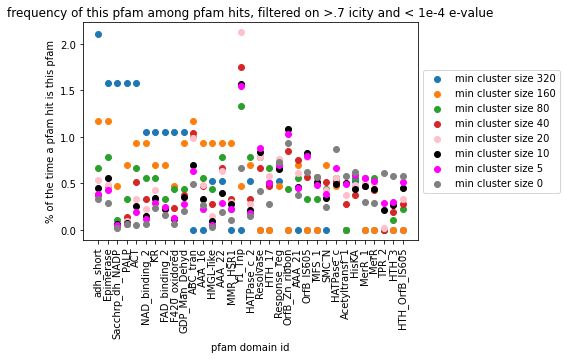

In [22]:
x_320, y_320 = list(dict_pfamfreq_320.keys()), list(dict_pfamfreq_320.values())
x_160, y_160 = list(dict_pfamfreq_160.keys()), list(dict_pfamfreq_160.values())
x_80, y_80 = list(dict_pfamfreq_80.keys()), list(dict_pfamfreq_80.values())
x_40, y_40 = list(dict_pfamfreq_40.keys()), list(dict_pfamfreq_40.values())
x_20, y_20 = list(dict_pfamfreq_20.keys()), list(dict_pfamfreq_20.values())
x_10, y_10 = list(dict_pfamfreq_10.keys()), list(dict_pfamfreq_10.values())
x_5, y_5 = list(dict_pfamfreq_5.keys()), list(dict_pfamfreq_5.values())
x_0, y_0 = list(dict_pfamfreq_0.keys()), list(dict_pfamfreq_0.values())
plt.scatter(x_320, y_320, label = "min cluster size 320")
plt.scatter(x_160, y_160, label = "min cluster size 160")
plt.scatter(x_80, y_80, label = "min cluster size 80")
plt.scatter(x_40, y_40, label = "min cluster size 40")
plt.scatter(x_20, y_20, label = "min cluster size 20", color = "pink")
plt.scatter(x_10, y_10, label = "min cluster size 10", color = "black")
plt.scatter(x_5, y_5, label = "min cluster size 5", color = "magenta")
plt.scatter(x_0, y_0, label = "min cluster size 0", color = "grey")
plt.xticks(rotation = 90)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("frequency of this pfam among pfam hits, filtered on >.7 icity and < 1e-4 e-value")
plt.xlabel("pfam domain id")
plt.ylabel("% of the time a pfam hit is this pfam")

Text(0, 0.5, '% of the time a pfam hit is this pfam')

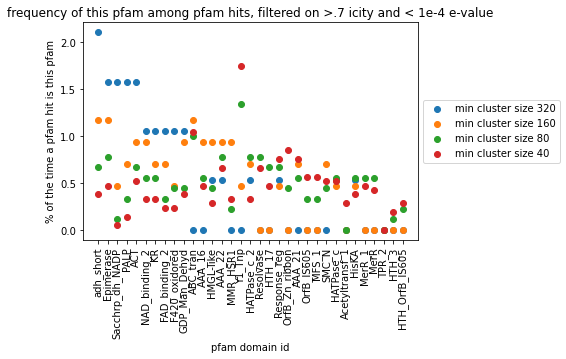

In [25]:
plt.scatter(x_320, y_320, label = "min cluster size 320")
plt.scatter(x_160, y_160, label = "min cluster size 160")
plt.scatter(x_80, y_80, label = "min cluster size 80")
plt.scatter(x_40, y_40, label = "min cluster size 40")
plt.xticks(rotation = 90)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("frequency of this pfam among pfam hits, filtered on >.7 icity and < 1e-4 e-value")
plt.xlabel("pfam domain id")
plt.ylabel("% of the time a pfam hit is this pfam")

Text(0, 0.5, '% of the time a pfam hit is this pfam')

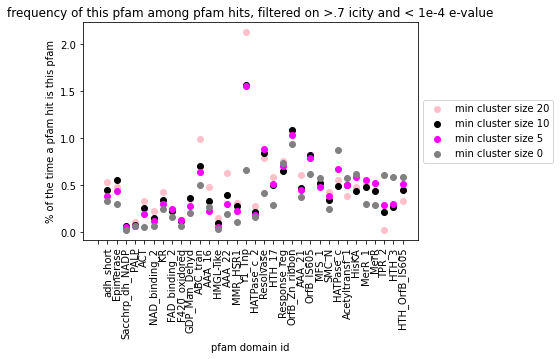

In [24]:
plt.scatter([" "], [1.6], color = "white")
plt.scatter(x_20, y_20, label = "min cluster size 20", color = "pink")
plt.scatter(x_10, y_10, label = "min cluster size 10", color = "black")
plt.scatter(x_5, y_5, label = "min cluster size 5", color = "magenta")
plt.scatter(x_0, y_0, label = "min cluster size 0", color = "grey")
plt.xticks(rotation = 90)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("frequency of this pfam among pfam hits, filtered on >.7 icity and < 1e-4 e-value")
plt.xlabel("pfam domain id")
plt.ylabel("% of the time a pfam hit is this pfam")

### explore tnpBs that colocalize


In [19]:
tnpB_df.shape[0]

122348

In [169]:
def dict_globaltop_pfam(df, pfamlist):
    queryid_frequency_dict = {}
    for pfam in pfamlist:
        key = pfam
        try:
            value = df["query_id"].value_counts()[pfam] / len(df["query_id"]) * 100
        except:
            value = 0
        queryid_frequency_dict[key] = value
    return queryid_frequency_dict

In [157]:
# get list of all tnpBs + similar proteins
tnpBs_list = []
infile_tnpBs = "tnpBs_in_testdb.p100.txt"
with open(infile_tnpBs, "r") as infile:
    lines = infile.readlines()
    for line in lines:
        p100 = line.split('\n')[0]
        tnpBs_list.append(p100)
# related_tnpB_baits = get_related_baits_pool(perm_reps)
# target_p100ids = list(get_bait_neighb_pool(tnpBs_list))

In [162]:
related_tnpB_baits = set(related_tnpB_baits)
tnpBs_set = set(tnpBs_list)

In [163]:
# orfBids = df_pfam_0[df_pfam_0["query_id"] == "OrfB_IS605"]["hit_id"]
# orfBids
sum([orfBid in tnpBs_list for orfBid in orfBids]), len(orfBids)

(432, 507)

In [164]:
# ZOOM OUT: are tnpB neighbours closely related (have same p30) to tnpBs?
targetids_highicity = set(tnpB_df["target_p100id"])
targetids_istnpB = set()
for targetid in targetids_highicity:
    if targetid in related_tnpB_baits:
        targetids_istnpB.add(targetid)

In [165]:
len(targetids_istnpB), len(targetids_highicity)

(2855, 122348)

In [166]:
list(targetids_istnpB)[0]

'ef06d28b55bab3e50d'

#### examine whether removing these colocalizing tnpBs change pfam results

In [186]:
def clean_pfamdf_notnpBs(df):
    return df.reset_index()[pd.Series([targetid not in targetids_istnpB for targetid in df["hit_id"]])]


In [196]:
df_pfam_10_clean = clean_pfamdf_notnpBs(df_pfam_10)
dict_topn_pfam(df_pfam_10_clean, 10), dict_topn_pfam(df_pfam_10, 10)

({'Y1_Tnp': 1.076158940397351,
  'ABC_tran': 0.7312362030905077,
  'Response_reg': 0.6622516556291391,
  'Epimerase': 0.5794701986754967,
  'MFS_1': 0.5380794701986755,
  'Acetyltransf_1': 0.5242825607064018,
  'HATPase_c': 0.510485651214128,
  'AAA_21': 0.4828918322295806,
  'adh_short': 0.4690949227373068,
  'Resolvase': 0.4690949227373068},
 {'Y1_Tnp': 1.5654019633855134,
  'OrfB_Zn_ribbon': 1.087821703369594,
  'Resolvase': 0.8357654550278589,
  'OrfB_IS605': 0.8224993366940834,
  'ABC_tran': 0.7031042716901035,
  'Response_reg': 0.6500397983550013,
  'Epimerase': 0.5571769700185725,
  'MFS_1': 0.5173786150172459,
  'Acetyltransf_1': 0.5041124966834705,
  'HTH_17': 0.5041124966834705})

Text(0.5, 1.0, 'number of pfam hits for proteins that colocalize with tnpBs with >.7 icity, with cluster sizes > 10')

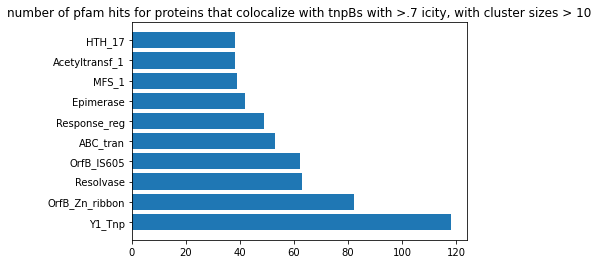

In [211]:
plt.barh(list(df_pfam_10["query_id"].value_counts().index)[:10], df_pfam_10["query_id"].value_counts()[:10])
plt.title("number of pfam hits for proteins that colocalize with tnpBs with >.7 icity, with cluster sizes > 10")

Text(0.5, 1.0, 'number of pfam hits for proteins that colocalize with tnpBs with >.7 icity, with cluster sizes > 10 and tnpBs filtered out')

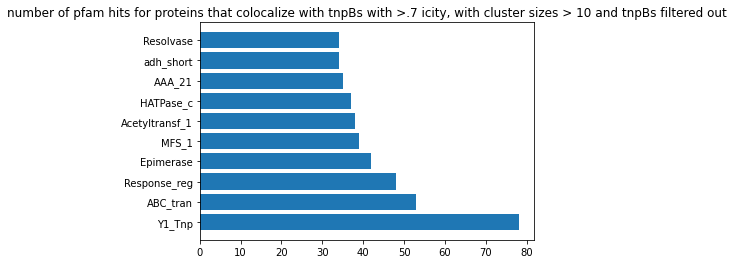

In [209]:
plt.barh(list(df_pfam_10_clean["query_id"].value_counts().index)[:10], df_pfam_10_clean["query_id"].value_counts()[:10])
plt.title("number of pfam hits for proteins that colocalize with tnpBs with >.7 icity, with cluster sizes > 10 and tnpBs filtered out")

In [ ]:
def dict_topn_pfam(df, n):
    queryid_frequency_dict = {}
    for i in range(n):
        key = df["query_id"].value_counts().index[i]
        value = df["query_id"].value_counts()[i] / len(df["query_id"]) * 100
        queryid_frequency_dict[key] = value
    return queryid_frequency_dict
dict_top10_320, dict_top10_160, dict_top10_80, dict_top10_40, dict_top10_20, dict_top10_10, dict_top10_5, dict_top10_0 = dict_topn_pfam(df_pfam_320, 10), dict_topn_pfam(df_pfam_160, 10), dict_topn_pfam(df_pfam_80, 10), dict_topn_pfam(df_pfam_40, 10), dict_topn_pfam(df_pfam_20, 10), dict_topn_pfam(df_pfam_10, 10), dict_topn_pfam(df_pfam_5, 10), dict_topn_pfam(df_pfam_0, 10)


### get distribution of the number of tnpB neighbours that are also tnpBs

In [167]:
count_neighbs_aretnpBs_ls = []
count_zero_ids = []
for targetid in targetids_istnpB:
    count = 0
    for neighbid in get_bait_neighbourhood(targetid):
        count += neighbid in related_tnpB_baits
    count_neighbs_aretnpBs_ls.append(count)
    if count == 0:
        count_zero_ids.append(targetid)

In [168]:
ex_countzeroid = count_zero_ids[2]
ex_countzeroid, ex_countzeroid in tnpBs_set

('a5c46d9bc01f864be2', True)

In [152]:
tnpBtarget_neighb = get_bait_neighbourhood(ex_countzeroid)
tnpBtarget_neighb, [neighbid in related_tnpB_baits for neighbid in tnpBtarget_neighb]

({'0f9326c2a887ac4992',
  '4494585d8b41aa279f',
  '622e3079f8812426d4',
  '73988aecee2008c4af',
  'be9b80e7e00600e221'},
 [False, False, False, False, False])

In [143]:
get_bait_neighbourhood('021c9f14e39dbb267e')

{'39b2e834a85af41ab3',
 '6360adc2a1f1595123',
 '99f13a6f74bc9d9f7b',
 'aa6d8e13cea10cfc69',
 'f0addf2189920eaca7',
 'f115264fec7be9e424',
 'ff90e9cbc11ca39c79'}

Text(0.5, 1.0, 'distribution of the number of tnpBs neighbours that are also tnpBs, among all high-icity hits')

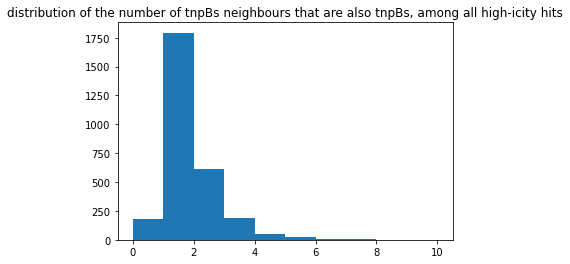

In [170]:
plt.hist(count_neighbs_aretnpBs_ls)
plt.title("distribution of the number of tnpBs neighbours that are also tnpBs, among all high-icity hits")

### explore data

(array([111355.,  59316.,  28828.,  32408.,  41076.,   5460.,   8550.,
          5667.,   2806., 113875.]),
 array([3.01386377e-04, 1.00271248e-01, 2.00241109e-01, 3.00210970e-01,
        4.00180832e-01, 5.00150693e-01, 6.00120555e-01, 7.00090416e-01,
        8.00060277e-01, 9.00030139e-01, 1.00000000e+00]),
 <BarContainer object of 10 artists>)

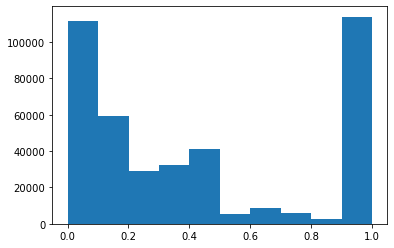

In [7]:
# icity_s = tnpB_df.iloc[:,1]
# plt.hist(icity_s)

In [50]:
# len_seq = []
# path_tnpB_multifaa = "hmmer_input_tnpb.faa"
# with open(path_tnpB_multifaa, 'w') as outfile:
#     for tnpBid in tnpB_df["target_p100id"]:
#         tnpB_seq = get_prot_sequence(tnpBid)
#         len_seq.append(len(tnpB_seq))
#         print(">" + tnpBid, file = outfile)
#         print(tnpB_seq, file = outfile)

Text(0.5, 1.0, 'distribution of protein lengths in tnpb neighbourhood')

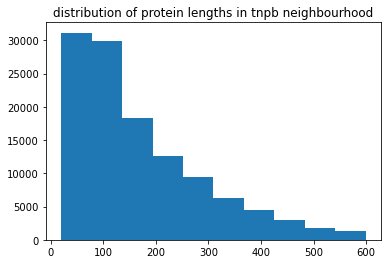

In [57]:
# plt.hist([l for l in len_seq if l < 600])
# plt.title("distribution of protein lengths in tnpb neighbourhood")

In [35]:
# os.system("wc -l hmmer_input_tnpb.faa")

244696 hmmer_input_tnpb.faa


0

In [36]:
# os.system("grep -c '>' hmmer_input_tnpb.faa")

122348


0

In [60]:
# os.system("tail -n 3 hmmer_input_tnpb.faa")

MTSTTVDAAAPRRGSSALAVLQRIGRSLMLPIAVLPAAALLLRFGQPDMLGADGLGWIRVAEVVGGAGQALFDHLPLLFAVGVAIGFAKKADGSTALAAVVGYLVFDQVSKIMFSHTDELKGNVLITKMVDGAPKEVIDFGAKNPTDVLGGILIGVVAALLYQRFYRVKLPTYLAFFGGRRFVPIITAVAALGIGVVIGFIWPVFGNWLTDFGNWITGAGALGAGIYGVVNRLLLPFGLHHIPNSLVWFVFGDYKGSDGVVHGEINRYLAGDPHAGGFLAGFFPVLMFGLPGAALAIWRAAPPHRRPAVGGIMISAALTAFVTGVTEPIEFAFMFVAPVLYAVHVVLTGISMAILEAAGAQLGFGFSAGGIDMLLNASKDNTKGLPLILGMGVLYFFIYYFVFKFLIVKFDFKTPGREPEDEDSVAADPDSNPELAAGTKPKKSRRRAAEDKAAEKEAGEEKAGDGTARPRDKGPAAPQDSPATS*
>f0bdeebd91979b22ba
MTTPTIELKPSSNPLSDAEREAILVKPGFGRYFTDHMVTIKWTDGRGWHDAQLVPYAPLSIDPANMTLHYGQEIFEGLKAYRQPDGTVATFRPEANAERFQSSARRLAMPELPVETFVAACDALVQQDAAWVPAHGGEESLYLRPFMIATEVGLGVRPSNEYLFLVIASPAGAYFPGGVKPVSIWLSEDRVRAVPGGMGDAKTGGNYAASLLAQAEAAAKGCDQVAYLDAVEHKWVEELGGMNLYFVYGNKIVTPALTGSLLAGITRDSLLRLAADLGYEPEENRVSIDQWRDDTANGTLTEVFACGTAAVITPVGTVKSASGEWTQGDGTPGPVTLRLRERLLDIQRGTAEDTHGWMHPLGXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXAEPVTRSRKGRAPGGRGLSALQDLERCSNLPAKGFIFSSLLVRVLL*


0

In [9]:
# with open("test.out.csv", "w") as outfile:
#     pfam_command = "hmmsearch --cpu {threads} -E 1 --domtblout {outtbl} {hmmfile} {seqdb}".format(
#     threads = 32, outtbl=outfile, hmmfile='../tnpBs/data/Pfam-A.hmm', seqdb="hmmer_input_tnpb.faa")

# tic = time.perf_counter()
# pfam_command = "hmmsearch --cpu {threads} -E 1 --domtblout {outtbl} {hmmfile} {seqdb}".format(
# threads = 32, outtbl="test.out.tsv", hmmfile='../tnpBs/data/Pfam-A.hmm', seqdb="hmmer_input_tnpb.faa")
# print(pfam_command)

hmmsearch --cpu 32 -E 1 --domtblout test.out.tsv ../tnpBs/data/Pfam-A.hmm hmmer_input_tnpb.faa
0.0003365260017744731


In [32]:
# with open("test.tmp.tsv", 'r') as infile, open("test.tmp.csv", "w") as outfile:
#     print("query_id,query_accession, query_len,hit_id,hit_evalue,target_length", file=outfile)
#     for qresult in SearchIO.parse(infile, 'hmmscan3-domtab'):
#         query_id = qresult.id  #sequence ID from fasta
#         query_accession = qresult.accession
#         query_len = qresult.seq_len
#         hits = qresult.hits
#         num_hits = len(hits)
#         if num_hits > 0:
#             for i in range(0,num_hits): 
#                 hit_evalue = hits[i].evalue
#                 # hmm_name = hits[i].accession
#                 target_length = hits[i].seq_len
#                 hit_id = hits[i].id
#                 out_row = ",".join([query_id, query_accession, str(query_len), hit_id, str(hit_evalue), str(target_length)])
#                 print(out_row, file=outfile)